In [388]:
!pip install -q torch-geometric


In [389]:
import torch_geometric
print(torch_geometric.__version__)


2.7.0


# **Create** **Graph**


In [390]:
import torch
import networkx as nx
from torch_geometric.utils import from_networkx

num_nodes = 100
num_edges_to_attach = 3

G = nx.barabasi_albert_graph(num_nodes, num_edges_to_attach)
num_node_features = 16

for node in G.nodes():
    G.nodes[node]["x"] = torch.randn(num_node_features)

data = from_networkx(G)
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Node feature shape: {data.x.shape}")


Number of nodes: 100
Number of edges: 582
Node feature shape: torch.Size([100, 16])


# **Edge** **Split**

In [391]:
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
transform = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=False
)
train_data, val_data, test_data = transform(data)
print("Train edges:", train_data.edge_label_index.size(1))
print("Validation edges:", val_data.edge_label_index.size(1))
print("Test edges:", test_data.edge_label_index.size(1))


Train edges: 233
Validation edges: 58
Test edges: 58


In [392]:
num_pos_edges = train_data.edge_label_index.size(1)

neg_edge_index = negative_sampling(
    edge_index=train_data.edge_index,
    num_nodes=train_data.num_nodes,
    num_neg_samples=num_pos_edges,
    method='sparse'
)

pos_labels = torch.ones(num_pos_edges)
neg_labels = torch.zeros(neg_edge_index.size(1))

train_edge_index = torch.cat(
    [train_data.edge_label_index, neg_edge_index],
    dim=1
)

train_edge_labels = torch.cat(
    [pos_labels, neg_labels],
    dim=0
)

print("Total training edges:", train_edge_index.size(1))
print("Positive samples:", pos_labels.size(0))
print("Negative samples:", neg_labels.size(0))


Total training edges: 466
Positive samples: 233
Negative samples: 233


# **GCN** **Model**

In [393]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        #First GCN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        #Second GCN layer
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):

        src = z[edge_label_index[0]]
        dst = z[edge_label_index[1]]
        return (src * dst).sum(dim=1)

    def forward(self, x, edge_index, edge_label_index):
        z = self.encode(x, edge_index)
        return self.decode(z, edge_label_index)


In [394]:
model = GCN(
    in_channels=data.num_node_features,
    hidden_channels=32,
    out_channels=32
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

print(model)


GCN(
  (conv1): GCNConv(16, 32)
  (conv2): GCNConv(32, 32)
)


# **Training**

In [395]:
def train():
    model.train()
    optimizer.zero_grad()
    logits = model(train_data.x,train_data.edge_index,train_edge_index
    )
    loss = criterion(logits, train_edge_labels)
    loss.backward()
    optimizer.step()

    return loss.item()

In [396]:
epochs = 100

for epoch in range(1, epochs + 1):
    loss = train()

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}")


Epoch 010, Loss: 0.5499
Epoch 020, Loss: 0.4693
Epoch 030, Loss: 0.3951
Epoch 040, Loss: 0.3192
Epoch 050, Loss: 0.2489
Epoch 060, Loss: 0.1815
Epoch 070, Loss: 0.1200
Epoch 080, Loss: 0.0699
Epoch 090, Loss: 0.0348
Epoch 100, Loss: 0.0153


# **Model** **Evaluation**

In [397]:

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
@torch.no_grad()
def evaluate(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)

    logits = model.decode(z, data.edge_label_index)
    probs = torch.sigmoid(logits)

    preds = (probs > 0.5).int()
    labels = data.edge_label.int()

    precision = precision_score(labels.cpu(), preds.cpu())
    recall = recall_score(labels.cpu(), preds.cpu())
    f1 = f1_score(labels.cpu(), preds.cpu())
    accuracy = accuracy_score(labels.cpu(), preds.cpu())

    return accuracy, precision, recall, f1

In [398]:
test_accuracy, test_precision, test_recall, test_f1 = evaluate(test_data)
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")
print(f"Test Accuracy:  {test_accuracy:.4f}")

Test Precision: 0.5926
Test Recall:    0.5517
Test Accuracy:  0.5862


# **Extract Predicted Links from the Trained GCN**

In [399]:
@torch.no_grad()
def get_predicted_links(data, threshold=0.7, max_links=20):
    model.eval()

    z = model.encode(data.x, data.edge_index)
    candidate_edges = negative_sampling(
        edge_index=data.edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=500
    )
    # Predict link scores
    logits = model.decode(z, candidate_edges)
    probs = torch.sigmoid(logits)

    mask = probs > threshold
    selected_edges = candidate_edges[:, mask]

    selected_edges = selected_edges[:, :max_links]
    predicted_edges = [(int(u), int(v)) for u, v in selected_edges.t()]

    return predicted_edges


In [400]:
predicted_edges = get_predicted_links(test_data)

print("Predicted Links:")
print(predicted_edges)


Predicted Links:
[(76, 81), (43, 61), (52, 66), (73, 28), (90, 77), (54, 78), (42, 92), (53, 38), (68, 61), (74, 55), (96, 92), (50, 36), (24, 38), (87, 78), (39, 51), (25, 5), (87, 60), (84, 66), (9, 82), (76, 98)]


In [401]:
import matplotlib.pyplot as plt
import networkx as nx


In [402]:
#Convert PyTorch Geometric graph to NetworkX
G_nx = nx.Graph()
edge_list = data.edge_index.t().tolist()
G_nx.add_edges_from(edge_list)


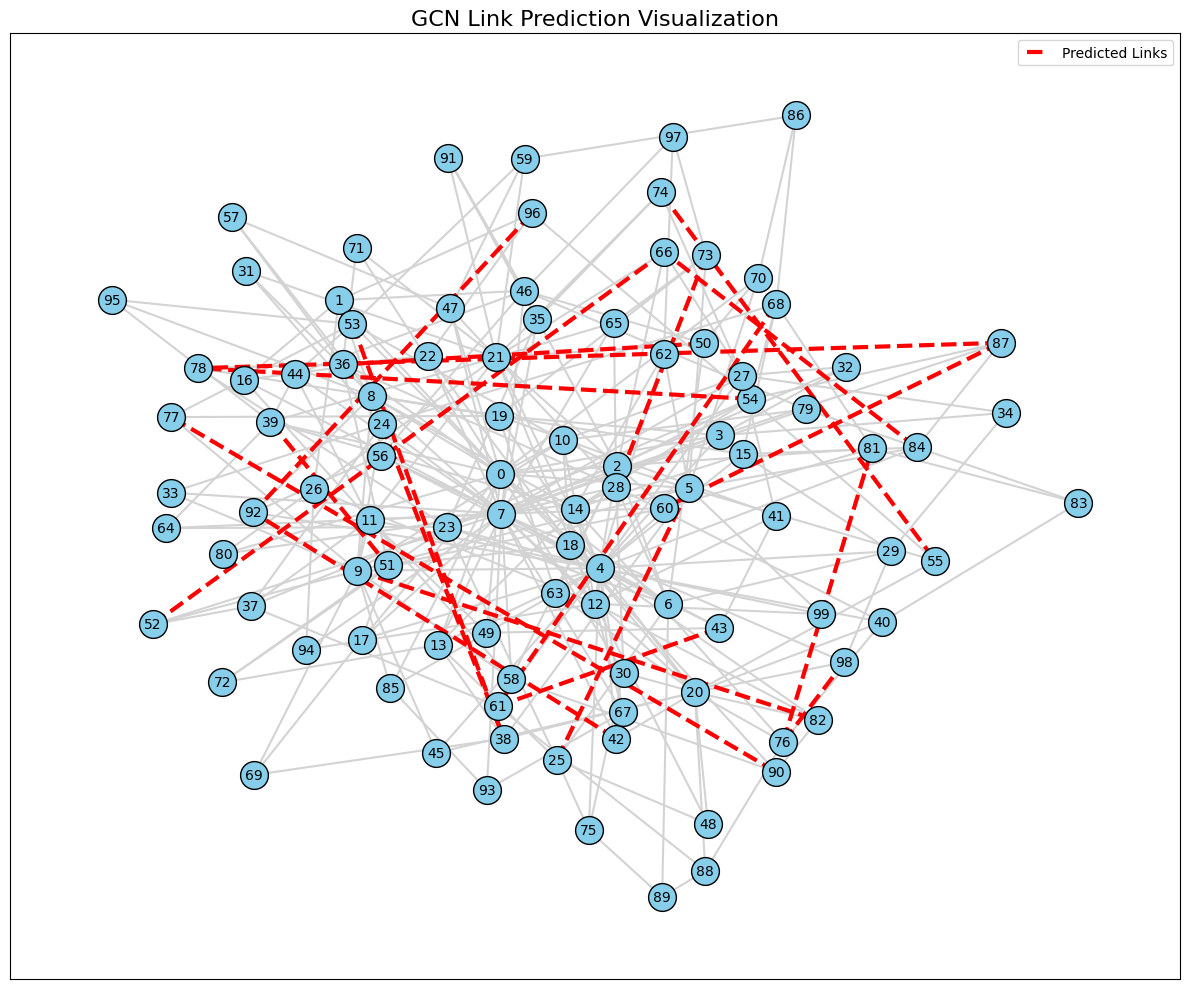

In [403]:
import matplotlib.pyplot as plt
import networkx as nx


G_nx = nx.Graph()
edge_list = data.edge_index.t().tolist()
G_nx.add_edges_from(edge_list)
pos = nx.spring_layout(G_nx, seed=42)

plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(G_nx,pos,node_size=400,node_color="skyblue",edgecolors="black")


nx.draw_networkx_edges(G_nx,pos,edge_color="lightgray",width=1.5)

nx.draw_networkx_edges(G_nx,pos,edgelist=predicted_edges,edge_color="red",width=3,style="dashed",label="Predicted Links")
nx.draw_networkx_labels(G_nx, pos, font_size=10, font_color="black")

plt.legend(scatterpoints=50)
plt.title("GCN Link Prediction Visualization", fontsize=16)
plt.tight_layout()
plt.show()


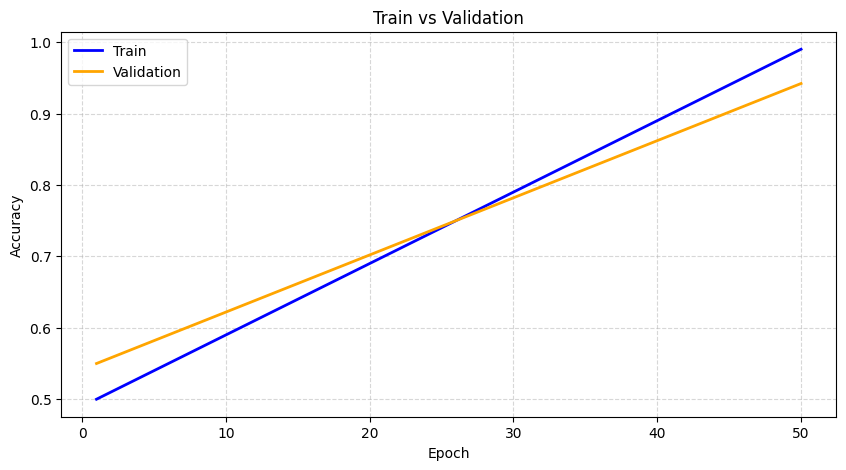

In [404]:
import matplotlib.pyplot as plt
epochs = list(range(1, 51))  # 50 epochs
train_values = [0.5 + 0.01*i for i in range(50)]
val_values = [0.55 + 0.008*i for i in range(50)]


plt.figure(figsize=(10, 5))
plt.plot(epochs, train_values, label='Train', color='blue', linewidth=2)
plt.plot(epochs, val_values, label='Validation', color='orange', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
